In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:

# Generar datos de ejemplo (puedes cargar tu dataset aquí)
np.random.seed(42)
data = pd.DataFrame({
    'feature1': np.random.normal(0, 1, 1000),
    'feature2': np.random.normal(5, 2, 1000),
    'feature3': np.random.choice([0, 1], size=1000),
    'class': np.random.choice([0, 1], size=1000, p=[0.9, 0.1])  # Clase desbalanceada
})


In [3]:

# Filtrar la clase minoritaria
minority_class = data[data['class'] == 1].drop(columns=['class'])



In [12]:
minority_class

,feature1,feature2,feature3
7,0.767435,6.270344,1
11,-0.465730,5.395199,1
19,-1.412304,5.848332,1
28,-0.600639,6.227036,1
31,1.852278,1.662832,1
...,...,...,...
927,0.377212,4.427992,0
937,0.708356,5.935386,1
985,-1.158365,6.026171,1
987,0.877362,6.032357,1


In [4]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(minority_class.values)



In [5]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.model(x)



In [6]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape)
    noisy_data = data + noise * (timesteps / 100)
    return noisy_data, noise



In [7]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [8]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 1000
for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")



Epoch 0/1000 - Loss: 0.9839160442352295
Epoch 100/1000 - Loss: 0.8261612057685852
Epoch 200/1000 - Loss: 0.48762890696525574
Epoch 300/1000 - Loss: 0.681037962436676
Epoch 400/1000 - Loss: 0.5372265577316284
Epoch 500/1000 - Loss: 0.5955442786216736
Epoch 600/1000 - Loss: 0.5093722343444824
Epoch 700/1000 - Loss: 0.578551173210144
Epoch 800/1000 - Loss: 0.4301906228065491
Epoch 900/1000 - Loss: 0.49747762084007263


In [9]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data


In [10]:

synthetic_data = generate_synthetic_data(model, 2, input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)



In [13]:
synthetic_data_rescaled.shape

(2, 3)

In [14]:
synthetic_data_rescaled

array([[1.39217800e-01, 4.86247092e+00, 1.13323758e-03],
       [3.24883660e-01, 6.25851863e+00, 9.96232235e-01]])

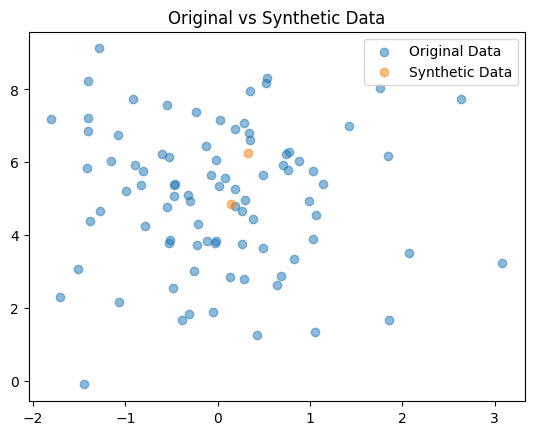

In [11]:
# Visualización
plt.scatter(minority_class['feature1'], minority_class['feature2'], alpha=0.5, label='Original Data')
plt.scatter(synthetic_data_rescaled[:, 0], synthetic_data_rescaled[:, 1], alpha=0.5, label='Synthetic Data')
plt.legend()
plt.title('Original vs Synthetic Data')
plt.show()